In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

Connect to Google drive, for later save the Model & Tokenizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Load The Data

In [3]:
# Load the train and dev datasets
train_df = pd.read_csv('train.csv', delimiter='|')
dev_df = pd.read_csv('dev.csv', delimiter='|')

# Ensure all reviews are strings and handle missing values
train_df['Review'] = train_df['Review'].astype(str).fillna('')
dev_df['Review'] = dev_df['Review'].astype(str).fillna('')

print(train_df.head())
print(dev_df.head())


                                              Review  Label
0  taste wise this is one of the best if not the ...      1
1  these donuts are the best i actual crave these...      1
2  at last i finally found an auto repair shop th...      1
3  this is an outdoor seating only starbucks ther...      0
4  being near my house and having seen it in the ...      0
                                              Review  Label
0  a cheaper choice but the service is absolutely...      0
1  babes is a very spacious bar with a lot of tab...      1
2  i have been taking the intro to natural childb...      1
3  i think italian ice is a stretch based on what...      0
4  in my view in the us there are generally three...      1


Load a Pretrained BERT Model from Hugging Face.

My first choice was: model_name = "bert-base-uncased".

since I am very limited in my computin power, after many tries and playing with every parameter, I decided to reduce the Model to a smaller one:

In [4]:
model_name = "distilbert-base-uncased"

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load the model (we use 2 output labels – positive and negative)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerN

savin the pretrained model, so we wuoldn't have to cennect to hugging face and download it every time...

In [5]:
model.save_pretrained("/content/drive/MyDrive/sentiment_model")
tokenizer.save_pretrained("/content/drive/MyDrive/sentiment_model")


('/content/drive/MyDrive/sentiment_model/tokenizer_config.json',
 '/content/drive/MyDrive/sentiment_model/special_tokens_map.json',
 '/content/drive/MyDrive/sentiment_model/vocab.txt',
 '/content/drive/MyDrive/sentiment_model/added_tokens.json')

Then we can reload them without redownloading from Hugging Face:

In [ ]:
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/sentiment_model")
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/sentiment_model")

Tokenize the Text Data

at first in max_length=512, but reduced for faster performance

In [6]:
train_encodings = tokenizer(
    train_df["Review"].tolist(), truncation=True, padding=True, max_length=128
)
dev_encodings = tokenizer(
    dev_df["Review"].tolist(), truncation=True, padding=True, max_length=128
)


Save the Encoded Data

Tokenization is slow too, so I save the train_encodings and dev_encodings objects

In [7]:
with open("/content/drive/MyDrive/train_encodings.pkl", "wb") as f:
    pickle.dump(train_encodings, f)

with open("/content/drive/MyDrive/dev_encodings.pkl", "wb") as f:
    pickle.dump(dev_encodings, f)


Then, next time:

In [ ]:
with open("/content/drive/MyDrive/train_encodings.pkl", "rb") as f:
    train_encodings = pickle.load(f)

with open("/content/drive/MyDrive/dev_encodings.pkl", "rb") as f:
    dev_encodings = pickle.load(f)


Create a PyTorch Dataset

In [8]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_df["Label"].tolist())
dev_dataset = SentimentDataset(dev_encodings, dev_df["Label"].tolist())


Evaluate the Model (Before Fine-Tuning):

Let’s test the pretrained BERT model on dev.csv before training, to see how it performs out of the box.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
def evaluate_model(model, dataset):
    model.eval()
    model.to(device)  # Ensure model is on GPU
    dataloader = DataLoader(dataset, batch_size=8)
    predictions, true_labels = [], []

    for batch in dataloader:
        # Move everything to GPU
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**{k: v for k, v in batch.items() if k != "labels"})
            logits = outputs.logits
            preds = torch.argmax(logits, axis=1)
            predictions.extend(preds.cpu().tolist())  # Move back to CPU for evaluation
            true_labels.extend(batch["labels"].cpu().tolist())

    acc = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {acc:.4f}")



In [11]:
# Evaluate before training
evaluate_model(model, dev_dataset)

Accuracy: 0.5000


Fine-Tune the Model (Training)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

model.to(device)

model.train()
epochs = 2

train_losses = []
dev_losses = []
train_accuracies = []
dev_accuracies = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}")
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch in tqdm(train_loader, leave=True):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, axis=1)
        correct_preds += (preds == batch["labels"]).sum().item()
        total_preds += batch["labels"].size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct_preds / total_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on dev set
    model.eval()
    dev_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    for batch in dev_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            dev_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, axis=1)
            correct_preds += (preds == batch["labels"]).sum().item()
            total_preds += batch["labels"].size(0)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(batch["labels"].cpu().tolist())

    avg_dev_loss = dev_loss / len(dev_dataset)
    dev_acc = correct_preds / total_preds
    dev_losses.append(avg_dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {avg_dev_loss:.4f} | Val Acc: {dev_acc:.4f}")

    torch.cuda.empty_cache()  # Auto-clear memory after each epoch


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1


100%|██████████| 2500/2500 [14:13<00:00,  2.93it/s]


Train Loss: 0.3236 | Train Acc: 0.8427
Val Loss: 0.0192 | Val Acc: 0.8966

Epoch 2


100%|██████████| 2500/2500 [14:17<00:00,  2.91it/s]


Train Loss: 0.1662 | Train Acc: 0.9365
Val Loss: 0.0127 | Val Acc: 0.9126


Save the Trained Model to your Drive

In [13]:
model.save_pretrained("/content/drive/MyDrive/sentiment_model")
tokenizer.save_pretrained("/content/drive/MyDrive/sentiment_model")


('/content/drive/MyDrive/sentiment_model/tokenizer_config.json',
 '/content/drive/MyDrive/sentiment_model/special_tokens_map.json',
 '/content/drive/MyDrive/sentiment_model/vocab.txt',
 '/content/drive/MyDrive/sentiment_model/added_tokens.json')

Later we can reload them

In [ ]:
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/sentiment_model")
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/sentiment_model")

To download the model directly to the computer

In [14]:
!zip -r sentiment_model.zip sentiment_model


	zip warning: name not matched: sentiment_model

zip error: Nothing to do! (try: zip -r sentiment_model.zip . -i sentiment_model)


In [15]:
# Evaluate again after training
evaluate_model(model, dev_dataset)

Accuracy: 0.9126


In [16]:
def plot_loss_and_accuracy_curves(train_losses, dev_losses, train_accuracies, dev_accuracies, title="Training Progress"):
    """
    Plots training and validation loss and accuracy curves.
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss Curves
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss", color="royalblue", linewidth=2)
    plt.plot(epochs, dev_losses, label="Validation Loss", color="orangered", linestyle="--", linewidth=2)
    plt.title(f"{title} - Loss", fontsize=14, fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot Accuracy Curves
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label="Training Accuracy", color="green", linewidth=2)
    plt.plot(epochs, dev_accuracies, label="Validation Accuracy", color="darkorange", linestyle="--", linewidth=2)
    plt.title(f"{title} - Accuracy", fontsize=14, fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_labels=["Negative", "Positive"], title="Confusion Matrix"):
    """
    Plots a confusion matrix using seaborn heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

def export_metrics_to_csv(train_losses, dev_losses, train_accuracies, dev_accuracies, epochs, filename="training_metrics.csv"):
    """
    Saves training and validation metrics to a CSV file.
    """
    df_metrics = pd.DataFrame({
        "epoch": list(range(1, epochs + 1)),
        "train_loss": train_losses,
        "val_loss": dev_losses,
        "train_acc": train_accuracies,
        "val_acc": dev_accuracies
    })
    df_metrics.to_csv(filename, index=False)

print("✅ Plotting and utility functions for loss, accuracy, and confusion matrix are now set up and ready to use.")


✅ Plotting and utility functions for loss, accuracy, and confusion matrix are now set up and ready to use.


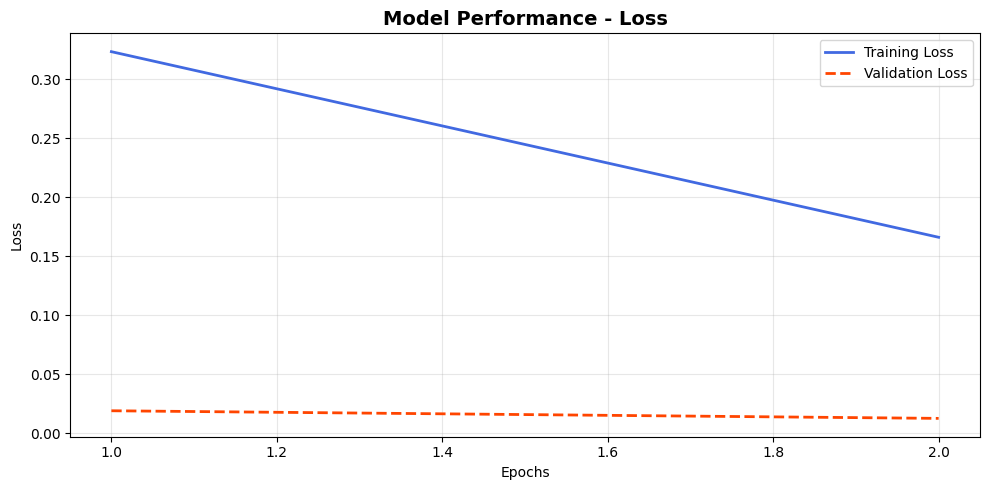

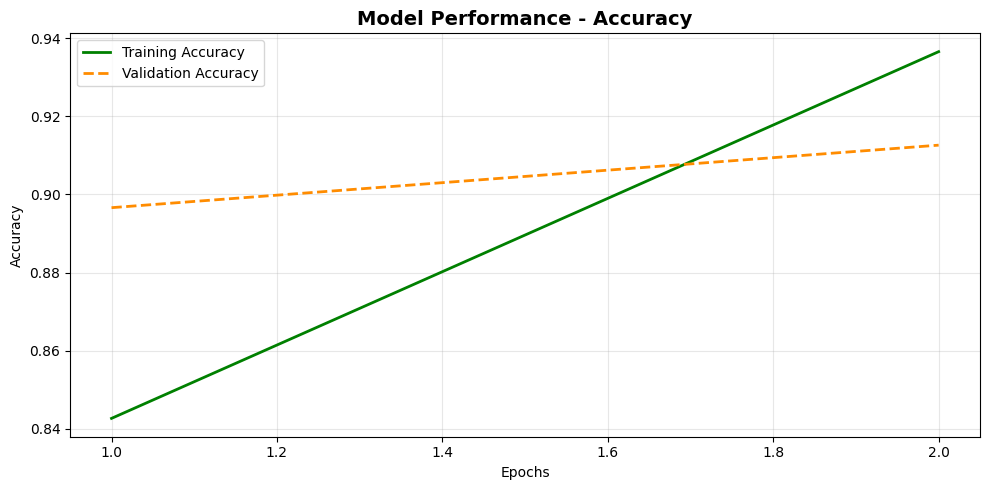

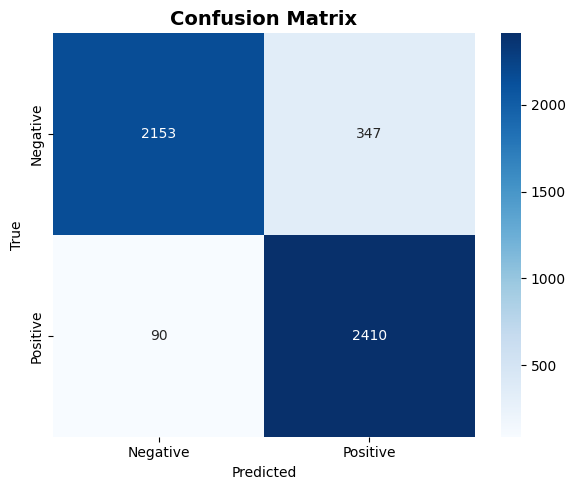

In [17]:
plot_loss_and_accuracy_curves(train_losses, dev_losses, train_accuracies, dev_accuracies, title="Model Performance")
plot_confusion_matrix(all_labels, all_preds, class_labels=["Negative", "Positive"])


Bonus: Exporting Metrics to CSV (Optional)

In [ ]:
import pandas as pd

df_metrics = pd.DataFrame({
    "epoch": list(range(1, epochs + 1)),
    "train_loss": train_losses,
    "val_loss": dev_losses,
    "train_acc": train_accuracies,
    "val_acc": dev_accuracies
})
df_metrics.to_csv("training_metrics.csv", index=False)
